In [3]:
import pandas as pd 
import geopandas as gpd
import numpy as np
from port_risk import data_path
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import statsmodels.api as sm
import scipy as sc
import seaborn as sns

In [4]:
risks = pd.read_csv(data_path["climate_data"])
risks = risks.rename(columns={'port_name': "name"})

risks["port_name"] = risks["name"] + "_" + risks["country"]
risks = risks.drop(["country", "name"], axis=1)

In [5]:
risks

,hazard,downtime,port_name
0,earthquake,0.010738,Komatsushima_Japan
1,earthquake,0.000000,Napoli_Italy
2,earthquake,0.000000,Bohai Bay_China
3,earthquake,0.000000,Tacoma_U.S.A.
4,earthquake,0.010698,Port Hueneme_U.S.A.
...,...,...,...
5071,operational,0.432568,Zhouliwang_China
5072,operational,0.461306,Zhoushan_China
5073,operational,0.027170,Zonguldak_Turkey
5074,operational,0.033438,palma De Mallorca_Spain


In [6]:
ports = gpd.read_file(data_path["ports"])
ports = ports.loc[ports["infra"] == "port"].reset_index(drop=True)
ports = ports.rename(columns={"name": "port_name"})
#ports["country"] = ports["port_name"].apply(lambda x: x.split("_")[1])
ports = ports.drop(["infra", "Continent_Code"], axis=1)

In [7]:
ports.__class__

geopandas.geodataframe.GeoDataFrame

In [8]:
port_risks = ports.copy()
port_risks = risks.merge(port_risks, on="port_name")
port_risks

,hazard,downtime,port_name,id,iso3,geometry
0,earthquake,0.010738,Komatsushima_Japan,port589,JPN,POINT (134.60158 34.04871)
1,earthquake,0.000000,Napoli_Italy,port795,ITA,POINT (14.27891 40.83925)
2,earthquake,0.000000,Bohai Bay_China,port154,CHN,POINT (117.86724 38.32313)
3,earthquake,0.000000,Tacoma_U.S.A.,port1248,USA,POINT (-122.39121 47.25357)
4,earthquake,0.010698,Port Hueneme_U.S.A.,port956,USA,POINT (-119.20945 34.15605)
...,...,...,...,...,...,...
5071,operational,0.432568,Zhouliwang_China,port1428,CHN,POINT (121.08299 37.70155)
5072,operational,0.461306,Zhoushan_China,port1429,CHN,POINT (122.10084 30.05635)
5073,operational,0.027170,Zonguldak_Turkey,port1430,TUR,POINT (31.87064 41.50089)
5074,operational,0.033438,palma De Mallorca_Spain,port1431,ESP,POINT (2.63271 39.55412)


In [9]:
port_risks = port_risks.set_index(['id','iso3',"geometry", "port_name", "hazard"]).unstack(level="hazard").replace(np.nan, 0)
port_risks.columns = ['downtime_TC','downtime_coastal','downtime_earthquake','downtime_fluvial','downtime_operational','downtime_pluvial']
port_risks["downtime_total"] = port_risks.sum(axis = 1)
port_risks = port_risks.reset_index()
port_risks_total = port_risks.copy().drop(['downtime_TC','downtime_coastal','downtime_earthquake','downtime_fluvial','downtime_operational','downtime_pluvial'], axis=1)

In [10]:
port_risks

,id,iso3,geometry,port_name,downtime_TC,downtime_coastal,downtime_earthquake,downtime_fluvial,downtime_operational,downtime_pluvial,downtime_total
0,port0,AUS,POINT (148.07762 -19.89376),Abbot Point_Australia,3.392091,0.000000,0.0,0.026554,0.027793,0.000000,3.446437
1,port1,DNK,POINT (9.42814 55.04254),Abenra_Denmark,0.000000,0.089220,0.0,0.000000,0.000000,0.000000,0.089220
2,port10,MAR,POINT (-9.64916 30.43858),Agadir_Morocco,0.141330,0.027881,0.0,0.000000,0.557620,0.000000,0.726831
3,port1000,BRA,POINT (-35.72301 -9.67954),Porto De Maceio_Brazil,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,port1001,BRA,POINT (-38.47154 -3.71344),Porto De Mucuripe_Brazil,0.002750,0.000000,0.0,0.015932,0.000315,0.069703,0.088701
...,...,...,...,...,...,...,...,...,...,...,...
1331,port995,USA,POINT (-70.26948 43.63649),"Portland, ME_U.S.A.",0.565066,0.000000,0.0,0.031864,0.000811,0.000000,0.597741
1332,port996,USA,POINT (-70.78807 43.09303),Portmouth_U.S.A.,1.076185,0.000000,0.0,0.012300,0.129640,0.000000,1.218124
1333,port997,BRA,POINT (-51.21938 -29.96646),Porto Alegre_Brazil,0.000000,0.000000,0.0,0.500157,1.085818,0.000000,1.585975
1334,port998,CPV,POINT (-23.49969 14.91005),Porto Da Praia_Cape Verde,0.670142,0.000000,0.0,0.000000,0.000000,0.000000,0.670142


In [11]:
port_risks_total

,id,iso3,geometry,port_name,downtime_total
0,port0,AUS,POINT (148.07762 -19.89376),Abbot Point_Australia,3.446437
1,port1,DNK,POINT (9.42814 55.04254),Abenra_Denmark,0.089220
2,port10,MAR,POINT (-9.64916 30.43858),Agadir_Morocco,0.726831
3,port1000,BRA,POINT (-35.72301 -9.67954),Porto De Maceio_Brazil,0.000000
4,port1001,BRA,POINT (-38.47154 -3.71344),Porto De Mucuripe_Brazil,0.088701
...,...,...,...,...,...
1331,port995,USA,POINT (-70.26948 43.63649),"Portland, ME_U.S.A.",0.597741
1332,port996,USA,POINT (-70.78807 43.09303),Portmouth_U.S.A.,1.218124
1333,port997,BRA,POINT (-51.21938 -29.96646),Porto Alegre_Brazil,1.585975
1334,port998,CPV,POINT (-23.49969 14.91005),Porto Da Praia_Cape Verde,0.670142


## TRADE ANALYSIS 

In [12]:
industries = pd.read_csv(data_path["industries"])

In [13]:
industries

,sector,Industries
0,Agriculture,1
1,Electrical and Machinery,9
2,Fishing,2
3,Food & Beverages,4
4,Metal Products,8
5,Mining and Quarrying,3
6,Other Manufacturing,10
7,"Petroleum, Chemical and Non-Metallic Mineral P...",7
8,Textiles and Wearing Apparel,5
9,Transport Equipment,11


In [14]:
network = pd.read_csv(data_path["network"])

In [15]:
network

,from_id,to_id,from_iso3,to_iso3,flow,iso3_O,iso3_D,q_sea_flow,v_sea_flow,q_sea_flow_sum,v_sea_flow_sum,share_mar,Industries,q_share_port,v_share_port,q_share_trade,v_share_trade,id,q_sea_predict,v_sea_predict
0,port0_in,port0_land,AUS,AUS,port_import,AFG,AUS,0.017152,1.037850e+02,1.250406,7.566123e+03,0.422863,1,0.013717,0.013717,0.005800,0.005800,port0,1.250406,7.566123e+03
1,port106_land,port106_out,IRN,IRN,port_export,AFG,AUS,0.256934,1.554687e+03,1.250406,7.566123e+03,0.422863,1,0.205480,0.205480,0.086890,0.086890,port106,1.250406,7.566123e+03
2,port1189_land,port1189_out,CHN,CHN,port_export,AFG,AUS,0.013345,8.074910e+01,1.250406,7.566123e+03,0.422863,1,0.010672,0.010672,0.004513,0.004513,port1189,1.250406,7.566123e+03
3,port1199_land,port1199_out,IND,IND,port_export,AFG,AUS,0.103989,6.292288e+02,1.250406,7.566123e+03,0.422863,1,0.083164,0.083164,0.035167,0.035167,port1199,1.250406,7.566123e+03
4,port1201_in,port1201_out,SGP,SGP,port_trans,AFG,AUS,0.552303,3.341946e+03,1.250406,7.566123e+03,0.422863,1,0.441699,0.441699,0.186778,0.186778,port1201,1.250406,7.566123e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2131911,port989_in,port989_land,TTO,TTO,port_import,BEL,TTO,0.739567,3.188716e+04,0.739567,3.188716e+04,0.718724,11,1.000000,1.000000,0.718724,0.718724,port989,0.739567,3.188716e+04
2131912,port985_land,port985_out,FRA,FRA,port_export,CHE,TTO,0.468161,1.604477e+05,0.468161,1.604477e+05,0.384369,11,1.000000,1.000000,0.384369,0.384369,port985,0.468161,1.604477e+05
2131913,port989_in,port989_land,TTO,TTO,port_import,CHE,TTO,0.468161,1.604477e+05,0.468161,1.604477e+05,0.384369,11,1.000000,1.000000,0.384369,0.384369,port989,0.468161,1.604477e+05
2131914,port985_land,port985_out,FRA,FRA,port_export,DEU,TTO,52.231816,3.077797e+06,52.231816,3.077797e+06,0.678970,11,1.000000,1.000000,0.678970,0.678970,port985,52.231816,3.077797e+06


In [16]:
network = network.merge(industries, on="Industries")

## For preprocessin module

In [17]:
def preprocess_trade(network, ports, iso3, industries: bool = False):
    groupby_list = [iso3]
    if industries:
        groupby_list += ["Industries", "sector"]

    country_flows = network.loc[network["flow"] == "port_import"].groupby(groupby_list)[["q_sea_flow", "v_sea_flow"]].sum()
    country_flows = country_flows.rename(columns = {'q_sea_flow':'q_sea_flow_total', "v_sea_flow": "v_sea_flow_total"})
    country_flows = country_flows.reset_index()

    country_flows_total = network.groupby([groupby_list[0]] + ["id"] + groupby_list[1:])[["q_sea_flow", "v_sea_flow"]].sum()
    country_flows_total = country_flows_total.reset_index()

    country_flows_total = country_flows_total.merge(country_flows, on=groupby_list)

    country_flows_total = country_flows_total.merge(ports, on = "id")
    country_flows_total = country_flows_total.rename(columns={iso3: "iso3", "iso3": "port_iso3"})

    return country_flows_total

In [18]:
export_trade = preprocess_trade(network, ports, "iso3_O", False)
export_trade_sector = preprocess_trade(network, ports, "iso3_O", True)
import_trade = preprocess_trade(network, ports, "iso3_D", False)
import_trade_sector = preprocess_trade(network, ports, "iso3_D", True)

In [19]:
def trade_risk(trade, risk, hazard: str = "downtime_total", industries: bool = False,):
    trade_risk = trade.merge(risk[["id", hazard]], on="id")
    trade_risk["q_flow_at_risk"] = (trade_risk['q_sea_flow'] / 365) * trade_risk[hazard]
    trade_risk['v_flow_at_risk'] = (trade_risk['v_sea_flow'] / 365) * trade_risk[hazard]

    trade_risk['downtime_q_weighted'] = (trade_risk['q_sea_flow'] / trade_risk['q_sea_flow_total']) * trade_risk[hazard]
    trade_risk['downtime_v_weighted'] = (trade_risk['v_sea_flow'] / trade_risk['v_sea_flow_total']) * trade_risk[hazard]

    groupby_list = ["iso3"]
    if industries:
        groupby_list += ['sector','Industries']

    network_trade_risk = trade_risk.groupby(groupby_list)[['downtime_q_weighted', "downtime_v_weighted"]].sum().reset_index()
    network_trade_risk = network_trade_risk.rename(columns={'downtime_q_weighted':'downtime_q_network', 'downtime_v_weighted':'downtime_v_network'})
    trade_risk = trade_risk.merge(network_trade_risk, on = groupby_list)

    return trade_risk


In [20]:
export_trade_risk = trade_risk(export_trade, port_risks_total, industries=False)
export_trade_risk_sector = trade_risk(export_trade_sector, port_risks_total, industries=True)
import_trade_risk = trade_risk(import_trade, port_risks_total, industries=False)
import_trade_risk_sector = trade_risk(import_trade_sector, port_risks_total, industries=True)

In [21]:
import_trade_risk

,iso3,id,q_sea_flow,v_sea_flow,q_sea_flow_total,v_sea_flow_total,port_name,port_iso3,geometry,downtime_total,q_flow_at_risk,v_flow_at_risk,downtime_q_weighted,downtime_v_weighted,downtime_q_network,downtime_v_network
0,ABW,port1000,28.039571,3.555304e+04,5.670243e+06,2.194395e+09,Porto De Maceio_Brazil,BRA,POINT (-35.72301 -9.67954),0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,6.710465,6.509124
1,ABW,port1001,743.206256,1.479718e+06,5.670243e+06,2.194395e+09,Porto De Mucuripe_Brazil,BRA,POINT (-38.47154 -3.71344),0.088701,0.180611,359.594205,1.162610e-05,5.981234e-05,6.710465,6.509124
2,ABW,port1002,261.458538,2.018676e+05,5.670243e+06,2.194395e+09,Porto De Suape_Brazil,BRA,POINT (-34.97291 -8.38947),0.819711,0.587179,453.350829,3.779738e-05,7.540715e-05,6.710465,6.509124
3,ABW,port1008,7.705017,1.227277e+04,5.670243e+06,2.194395e+09,Porto Di Palermo_Italy,ITA,POINT (13.36777 38.13021),0.228301,0.004819,7.676395,3.102269e-07,1.276837e-06,6.710465,6.509124
4,ABW,port101,253818.154716,7.357657e+07,5.670243e+06,2.194395e+09,Balboa_Panama,PAN,POINT (-79.56547 8.95532),0.464391,322.933915,93611.783096,2.078762e-02,1.557072e-02,6.710465,6.509124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148388,ZWE,port99,8.536409,8.427612e+04,2.284558e+06,2.829602e+09,Bakar_Croatia,HRV,POINT (14.54213 45.28954),0.005668,0.000133,1.308743,2.117950e-08,1.688192e-07,2.357902,2.399038
148389,ZWE,port990,4.407843,2.174610e+04,2.284558e+06,2.829602e+09,Port-De-Bouc_France,FRA,POINT (5.00920 43.38879),0.945992,0.011424,56.360661,1.825205e-06,7.270153e-06,2.357902,2.399038
148390,ZWE,port991,11.900242,3.845403e+03,2.284558e+06,2.829602e+09,Port-La-Nouvelle_France,FRA,POINT (3.05414 43.02316),0.913137,0.029771,9.620222,4.756524e-06,1.240945e-06,2.357902,2.399038
148391,ZWE,port997,0.763455,7.683276e+02,2.284558e+06,2.829602e+09,Porto Alegre_Brazil,BRA,POINT (-51.21938 -29.96646),1.585975,0.003317,3.338489,5.300020e-07,4.306430e-07,2.357902,2.399038


In [22]:
def merge_risk(import_risk, export_risk, quantity: bool = False, industries: bool = False):

    col_name = f"downtime_{'q' if quantity else 'v'}_weighted"
    sea_flow_total = f"{'q' if quantity else 'v'}_sea_flow_total"

    iso3 = "iso3"
    if industries:
        import_risk["iso3_sector"] =import_risk["iso3"] + "_" + import_risk["sector"]
        export_risk["iso3_sector"] =export_risk["iso3"] + "_" + export_risk["sector"]
        iso3 = "iso3_sector"
       

    domestic_import_risk = import_risk.loc[import_risk["iso3"] == import_risk['port_iso3']].groupby(iso3)[col_name].sum()
    domestic_import_risk = domestic_import_risk.rename("domestic_import_risk")
    foreign_import_risk = import_risk.loc[import_risk["iso3"] != import_risk['port_iso3']].groupby(iso3)[col_name].sum()
    foreign_import_risk = foreign_import_risk.rename("foreign_import_risk")

    domestic_export_risk = export_risk.loc[export_risk["iso3"] == export_risk['port_iso3']].groupby(iso3)[col_name].sum()
    domestic_export_risk = domestic_export_risk.rename("domestic_export_risk")
    foreign_export_risk = export_risk.loc[export_risk["iso3"] != export_risk['port_iso3']].groupby(iso3)[col_name].sum()
    foreign_export_risk = foreign_export_risk.rename("foreign_export_risk")

    global_risk = pd.concat([domestic_import_risk, foreign_export_risk, domestic_export_risk, foreign_import_risk], axis=1)

    total_import = import_risk[[iso3, sea_flow_total]].drop_duplicates().rename(columns={sea_flow_total: "imports"}).set_index(iso3)
    total_exports = export_risk[[iso3, sea_flow_total]].drop_duplicates().rename(columns={sea_flow_total: "exports"}).set_index(iso3)

    global_risk = pd.concat([global_risk, total_import, total_exports], axis=1)


    ports_import = import_risk.groupby(iso3)["id"].nunique().rename("n_ports_import")
    ports_export = export_risk.groupby(iso3)["id"].nunique().rename("n_ports_export")

    global_risk = pd.concat([global_risk, ports_import, ports_export], axis=1)

    global_risk = global_risk.replace(np.nan, 0.).reset_index()


    global_risk["total_import_risk"] = global_risk["domestic_import_risk"] + global_risk["foreign_import_risk"]
    global_risk["total_export_risk"] = global_risk["domestic_export_risk"] + global_risk["foreign_export_risk"]
    global_risk["total_risk"] = (global_risk["total_import_risk"] * global_risk["imports"]) / (global_risk[["imports", "exports"]].sum(axis=1))
    global_risk["total_risk"].add((global_risk["total_export_risk"] * global_risk["exports"]) / (global_risk[["imports", "exports"]].sum(axis=1)))

    if industries:
        global_risk["iso3"] = global_risk["iso3_sector"].apply(lambda x: x.split("_")[0])
        global_risk["sector"] = global_risk["iso3_sector"].apply(lambda x: x.split("_")[1])

    return global_risk

In [23]:
global_trade_risk= merge_risk(import_trade_risk, export_trade_risk)
global_trade_risk_quantity = merge_risk(import_trade_risk, export_trade_risk, quantity=True)

In [24]:
global_trade_risk_quantity

,iso3,domestic_import_risk,foreign_export_risk,domestic_export_risk,foreign_import_risk,imports,exports,n_ports_import,n_ports_export,total_import_risk,total_export_risk,total_risk
0,ABW,3.872873,3.668763,3.863552,2.837592,5.670243e+06,5.757718e+05,411,257.0,6.710465,7.532315,6.091879
1,AGO,0.461757,2.692579,2.141819,1.929089,1.168777e+07,9.842082e+07,925,903.0,2.390846,4.834398,0.253783
2,ALB,0.061263,2.305475,0.045181,1.758128,1.983899e+06,2.582772e+06,607,810.0,1.819392,2.350656,0.790398
3,ARE,0.134620,1.918582,0.095384,2.492576,7.415025e+07,2.150478e+08,1044,997.0,2.627196,2.013965,0.673612
4,ARG,0.217353,2.380072,0.790866,2.215656,2.748140e+07,7.846408e+07,981,1122.0,2.433009,3.170938,0.631103
...,...,...,...,...,...,...,...,...,...,...,...,...
203,UGA,0.000000,1.370218,0.000000,2.398777,4.183169e+06,1.263891e+06,858,802.0,2.398777,1.370218,1.842185
204,UZB,0.000000,4.037225,0.000000,5.278735,3.080569e+06,8.688135e+05,611,834.0,5.278735,4.037225,4.117481
205,WLF,0.000000,5.618446,0.000000,9.057824,1.988414e+04,6.128510e+01,178,72.0,9.057824,5.618446,9.029992
206,ZMB,0.000000,4.328540,0.000000,4.515201,3.351530e+06,2.207402e+06,790,677.0,4.515201,4.328540,2.722256


In [25]:
global_trade_risk

,iso3,domestic_import_risk,foreign_export_risk,domestic_export_risk,foreign_import_risk,imports,exports,n_ports_import,n_ports_export,total_import_risk,total_export_risk,total_risk
0,ABW,3.878126,3.311250,3.864623,2.630998,2.194395e+09,3.021787e+08,411,257.0,6.509124,7.175873,5.721277
1,AGO,0.366837,2.669461,2.099846,2.087741,1.467868e+10,3.386783e+10,925,903.0,2.454578,4.769307,0.742174
2,ALB,0.062564,2.287734,0.061964,1.973240,1.588691e+09,8.798875e+08,607,810.0,2.035804,2.349698,1.310172
3,ARE,0.122082,2.120018,0.094431,2.544520,1.151296e+11,1.206280e+11,1044,997.0,2.666602,2.214449,1.302206
4,ARG,0.123021,2.123346,0.645920,2.862912,3.798969e+10,4.164471e+10,981,1122.0,2.985933,2.769266,1.424443
...,...,...,...,...,...,...,...,...,...,...,...,...
203,UGA,0.000000,1.204312,0.000000,1.783940,3.943460e+09,1.352449e+09,858,802.0,1.783940,1.204312,1.328364
204,UZB,0.000000,3.967078,0.000000,4.289936,2.169588e+09,8.515899e+08,611,834.0,4.289936,3.967078,3.080717
205,WLF,0.000000,6.526404,0.000000,8.544741,3.120680e+07,5.366029e+05,178,72.0,8.544741,6.526404,8.400297
206,ZMB,0.000000,4.903280,0.000000,4.492463,4.485515e+09,7.378191e+09,790,677.0,4.492463,4.903280,1.698542


## statistical hypothesis

In [284]:
data = export_trade_risk.copy()
data = data.drop(["geometry", "iso3", "port_name", "port_iso3"], axis=1)
data["id"] = data["id"].apply(lambda x: x[4:])
data.head()

,id,q_sea_flow,v_sea_flow,q_sea_flow_total,v_sea_flow_total,downtime_total,q_flow_at_risk,v_flow_at_risk,downtime_q_weighted,downtime_v_weighted,downtime_q_network,downtime_v_network
0,1004,211.756226,2.531671e+03,575771.844605,3.021787e+08,0.392421,2.276645e-01,2.721864,1.443238e-04,3.287725e-06,7.532315,7.175873
1,1005,175.546051,2.098757e+03,575771.844605,3.021787e+08,0.516808,2.485578e-01,2.971656,1.575686e-04,3.589446e-06,7.532315,7.175873
2,101,1533.086993,1.649995e+07,575771.844605,3.021787e+08,0.464391,1.950553e+00,20992.958454,1.236517e-03,2.535728e-02,7.532315,7.175873
3,1010,0.000137,2.185453e+02,575771.844605,3.021787e+08,0.006149,2.313110e-09,0.003682,1.466354e-12,4.447409e-09,7.532315,7.175873
4,1021,0.019448,2.234913e+02,575771.844605,3.021787e+08,0.001308,6.968677e-08,0.000801,4.417665e-11,9.672984e-10,7.532315,7.175873


In [285]:
data.describe()

,q_sea_flow,v_sea_flow,q_sea_flow_total,v_sea_flow_total,downtime_total,q_flow_at_risk,v_flow_at_risk,downtime_q_weighted,downtime_v_weighted,downtime_q_network,downtime_v_network
count,1.567200e+05,1.567200e+05,1.567200e+05,1.567200e+05,156720.000000,1.567200e+05,1.567200e+05,1.567200e+05,1.567200e+05,156720.000000,156720.000000
mean,1.741916e+05,1.234749e+08,6.555173e+07,5.284296e+10,1.294654,7.541841e+02,5.203197e+05,5.073406e-03,4.746377e-03,3.633424,3.376770
std,2.854402e+06,2.079483e+09,1.610256e+08,1.314555e+11,1.894949,2.433922e+04,1.651730e+07,7.110825e-02,6.865134e-02,2.096160,1.869286
min,3.364638e-10,4.749724e-07,6.128510e+01,5.366029e+05,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.216811,0.359104
25%,4.582147e+00,1.023924e+04,2.001357e+06,1.212973e+09,0.141518,3.083535e-03,7.289047e+00,2.948293e-07,8.098120e-07,1.968606,1.992987
50%,2.320427e+02,3.113934e+05,1.108893e+07,6.982727e+09,0.541022,2.435185e-01,3.347497e+02,1.123444e-05,1.924191e-05,3.201971,2.978941
75%,6.694317e+03,6.360804e+06,6.473271e+07,4.368819e+10,1.634668,9.712935e+00,9.347517e+03,2.330391e-04,2.991043e-04,4.610932,4.345808
max,6.271699e+08,3.591948e+11,1.405014e+09,1.120182e+12,17.185498,7.405764e+06,3.365896e+09,7.897588e+00,7.960429e+00,13.898256,12.482268


In [250]:
corr_matrix = data.corr()

<Axes: >

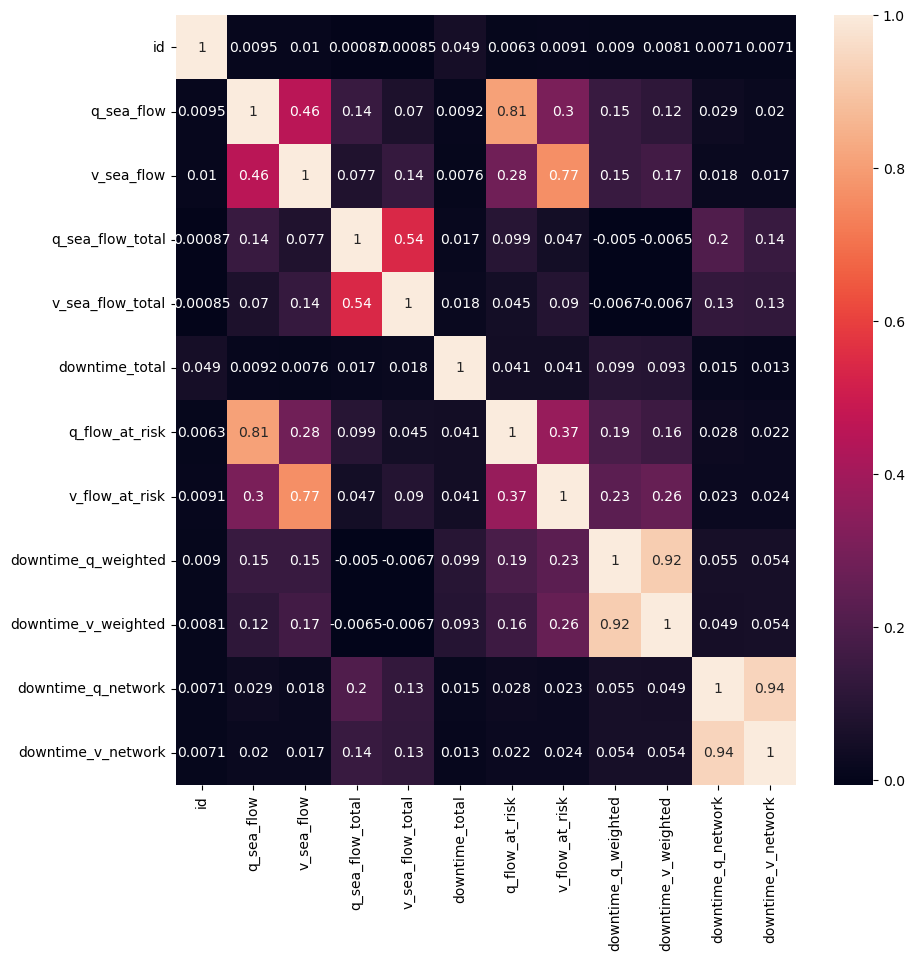

In [251]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True)

In [252]:
data.head()

,id,q_sea_flow,v_sea_flow,q_sea_flow_total,v_sea_flow_total,downtime_total,q_flow_at_risk,v_flow_at_risk,downtime_q_weighted,downtime_v_weighted,downtime_q_network,downtime_v_network
0,1004,211.756226,2.531671e+03,575771.844605,3.021787e+08,0.392421,2.276645e-01,2.721864,1.443238e-04,3.287725e-06,7.532315,7.175873
1,1005,175.546051,2.098757e+03,575771.844605,3.021787e+08,0.516808,2.485578e-01,2.971656,1.575686e-04,3.589446e-06,7.532315,7.175873
2,101,1533.086993,1.649995e+07,575771.844605,3.021787e+08,0.464391,1.950553e+00,20992.958454,1.236517e-03,2.535728e-02,7.532315,7.175873
3,1010,0.000137,2.185453e+02,575771.844605,3.021787e+08,0.006149,2.313110e-09,0.003682,1.466354e-12,4.447409e-09,7.532315,7.175873
4,1021,0.019448,2.234913e+02,575771.844605,3.021787e+08,0.001308,6.968677e-08,0.000801,4.417665e-11,9.672984e-10,7.532315,7.175873


In [253]:
data = data[(data["downtime_q_weighted"] != 0 )& (data["downtime_v_weighted"] != 0 )]

<Axes: >

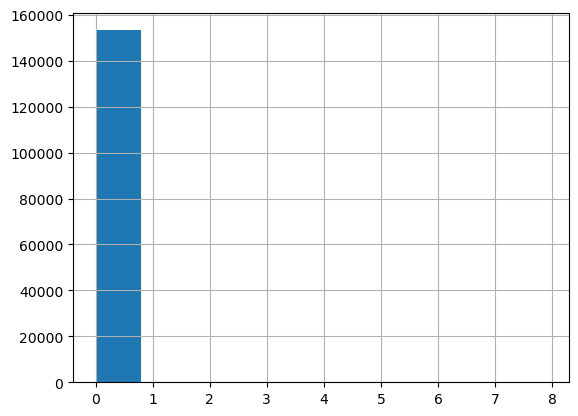

In [254]:
data["downtime_q_weighted"].hist()

In [255]:
data.shape

(153387, 12)

In [270]:
data = data.loc[data["downtime_q_weighted"] < np.power(10, float(-4))]

In [271]:
data.describe()

,q_sea_flow,v_sea_flow,q_sea_flow_total,v_sea_flow_total,downtime_total,q_flow_at_risk,v_flow_at_risk,downtime_q_weighted,downtime_v_weighted,downtime_q_network,downtime_v_network
count,1.037130e+05,1.037130e+05,1.037130e+05,1.037130e+05,103713.000000,1.037130e+05,1.037130e+05,1.037130e+05,1.037130e+05,103713.000000,103713.000000
mean,1.148551e+04,9.663266e+06,6.263362e+07,4.899675e+10,0.997888,2.344005e+00,3.620896e+03,1.242197e-05,5.074829e-05,3.641922,3.390007
std,4.042200e+05,2.185175e+08,1.617768e+08,1.250832e+11,1.594587,1.149696e+01,2.328281e+04,2.166017e-05,5.103043e-04,2.125809,1.897115
min,3.364638e-10,4.749724e-07,6.128510e+01,5.366029e+05,0.000030,9.290718e-13,1.311533e-09,1.280896e-17,8.901153e-17,0.216811,0.359104
25%,8.597932e-01,2.544539e+03,1.814352e+06,1.128552e+09,0.096435,6.911366e-04,2.010784e+00,7.789374e-08,2.608287e-07,1.907645,1.992987
50%,2.732011e+01,4.990764e+04,1.059801e+07,6.434807e+09,0.403049,2.541015e-02,4.575011e+01,1.585196e-06,3.451676e-06,3.201971,3.048138
75%,5.334551e+02,7.566338e+05,6.080051e+07,4.041999e+10,1.148988,4.945579e-01,6.736032e+02,1.385171e-05,2.409719e-05,4.709016,4.356861
max,9.123271e+07,3.659726e+10,1.405014e+09,1.120182e+12,17.185498,3.795450e+02,1.436804e+06,9.998387e-05,6.656622e-02,13.898256,12.482268


<Axes: >

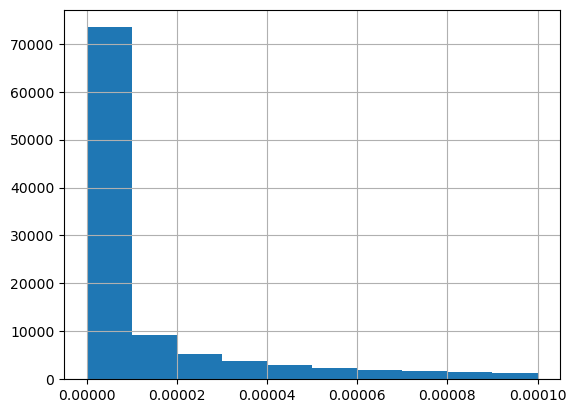

In [272]:
data["downtime_q_weighted"].hist()

<Axes: >

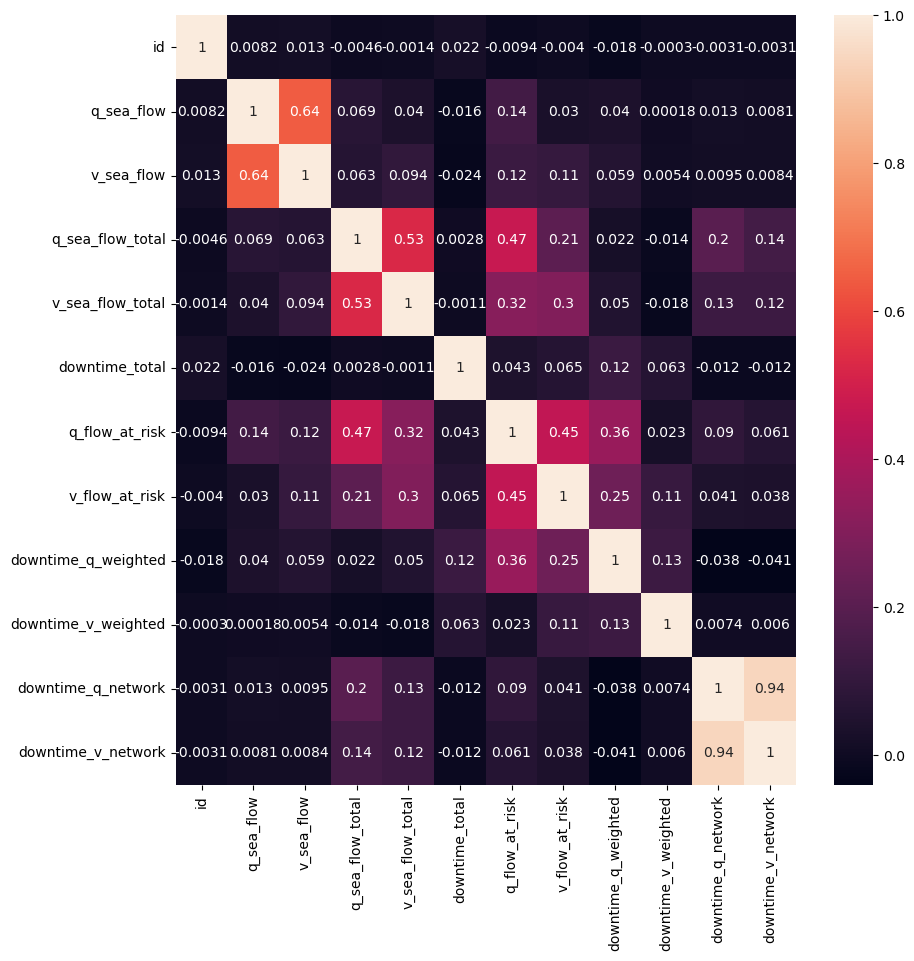

In [273]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True)

In [274]:
y = data["downtime_q_weighted"]
y1 = data["downtime_v_weighted"]
X = data.drop(["downtime_q_weighted","downtime_v_weighted" ], axis=1).to_numpy()

In [288]:
import sklearn as sk

In [289]:
print(sk.__version__)

1.3.0


In [294]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [296]:
model = GradientBoostingRegressor()
model = model.fit(X_train, y_train)

In [279]:
y_pred = model.predict(X_test)

In [280]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mae)
print(mse)
print(r2)

3.1889481424110524e-07
1.1013723672433288e-12
0.9976696614719813


In [132]:
y_pred = model.predict(X_test)

In [133]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mae)
print(mse)
print(r2)

0.2798843891588301
0.8180786088669332
0.9987513856031723


In [281]:
model = ExtraTreesRegressor()
model = model.fit(X_train, y_train)

In [282]:
y_pred = model.predict(X_test)

In [283]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mae)
print(mse)
print(r2)

2.298302439468885e-07
5.915209599843552e-13
0.9987484304816615
